In [1]:
import math
import time
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

import Scripts.fishUtilities as fu
import Scripts.fishFits as ff

from pathlib import Path

In [2]:
imagePath = r'./Pictures'
databasePath = r'./'
figurePath = r'/home/mco143/Documents/gitRepos/fish_contours/Figures'
    
specimen = r'commonCarp'

In [3]:
imagePathSide = fu.get_image_files(imagePath, specimen + 'SideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, specimen + 'Side.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())

imagePathTop = fu.get_image_files(imagePath, specimen + 'TopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, specimen + 'Top.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop

# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

In [4]:
# Split work depending on input images
def process_top(imageList):
    # make a copy of the image
    topImage = imageList[0].copy()
    if(len(imageList) < 2):
        topImageFull = imageList[0].copy()
    else:
        topImageFull = imageList[1].copy()
    # get contours
    cntsTop, hullTop = fu.get_contours(topImage)
    cntsTopFull, hullTopFull = fu.get_contours(topImageFull)
    
    # Find the area ratio of fins and no fins
    areaTopFull = cv2.contourArea(cntsTopFull)
    areaTopNF = cv2.contourArea(cntsTop)
    areaRatioTop = (1-np.abs(areaTopNF/areaTopFull))

    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(topImage.shape, cntsTop)
    (cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(topImageFull.shape, cntsTopFull)

    # find the dividing lines
    leftMost = tuple(cntsTop[cntsTop[:,:,0].argmin()][0])
    rightMost = tuple(cntsTop[cntsTop[:,:,0].argmax()][0])
    #topMost = tuple(cnts[cnts[:,:,1].argmin()][0])
    #bottomMost = tuple(cnts[cnts[:,:,1].argmax()][0])
    
    # scale contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    areaTopFull, tHullTopFull, bHullTopFull = fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    
    return ([cxTop, cyTop], [leftMost, rightMost], [cntsTop, cntsTopFull], [tHullTop, bHullTop])

In [5]:
def process_side(imageList):
    # make a copy of the image
    sideImage = imageList[0].copy()
    sideImageFull = imageList[1].copy()

    # get contours
    cntsSide, hullSide = fu.get_contours(sideImage)
    cntsSideFull, hullSideFull = fu.get_contours(sideImageFull)
    
    (cxSide, cySide), areaSideNF, topHullSide, bottomHullSide = fu.split_by_centroid_side(sideImage.shape, cntsSide)
    (cxSideFull, cySideFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(sideImageFull.shape, cntsSideFull)
    
    # find the dividing lines
    leftMost = tuple(cntsSide[cntsSide[:,:,0].argmin()][0])
    rightMost = tuple(cntsSide[cntsSide[:,:,0].argmax()][0])
    midPoint_left = (int(leftMost[0] + (cxSide-leftMost[0])/2), cySide)
    midPoint_right = (int(cxSide + (rightMost[0]-cxSide)/2), cySide)
    
    # scale contour data
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    
    return ([cxSide, cySide], [leftMost, rightMost], [cntsSide, cntsSideFull], [tHullSide, bHullSide])

In [6]:
hsvSideFull = cv2.cvtColor(imageSideFull, cv2.COLOR_BGR2HSV)
# split the channels
h, s, v = cv2.split(hsvSideFull)
# Gaussian filter the s and v component
s = cv2.GaussianBlur(s, (3,3), 1)
v = cv2.GaussianBlur(v, (3,3), 1)
# append the images
hsvSideFull_processed = cv2.merge([h, s, v])

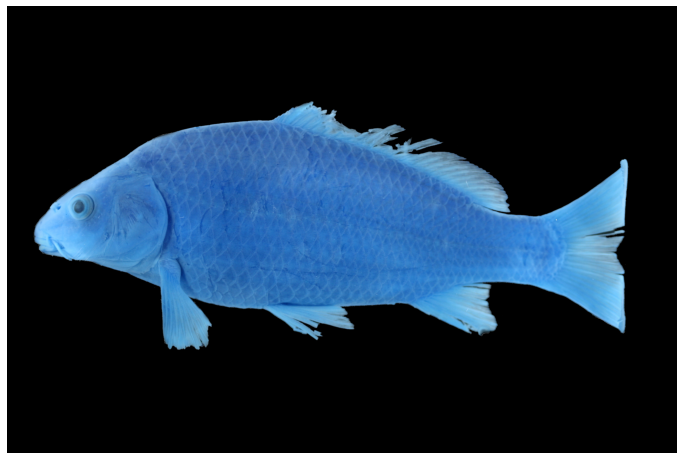

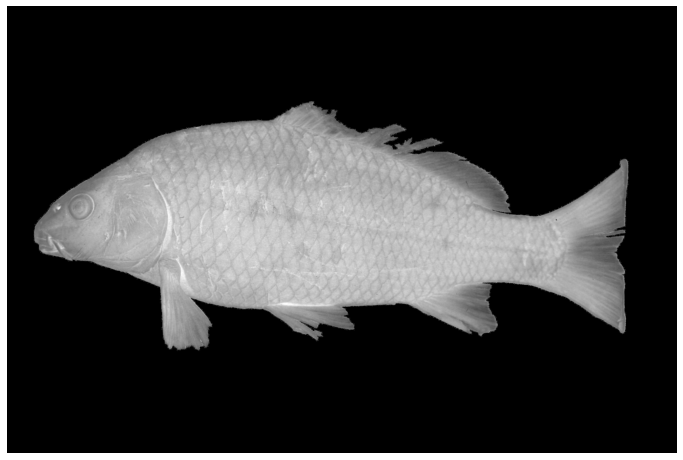

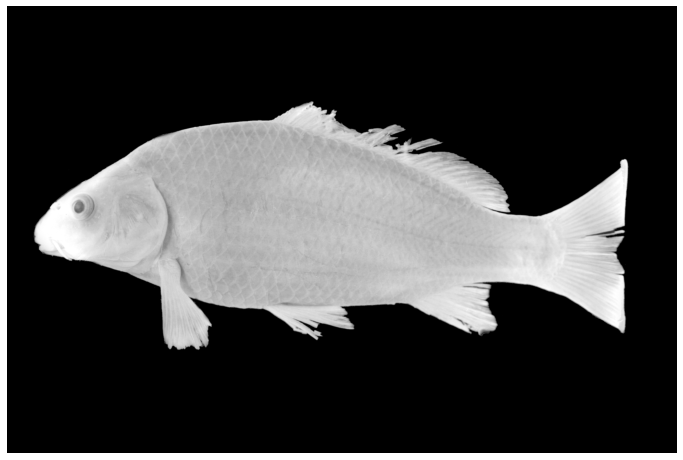

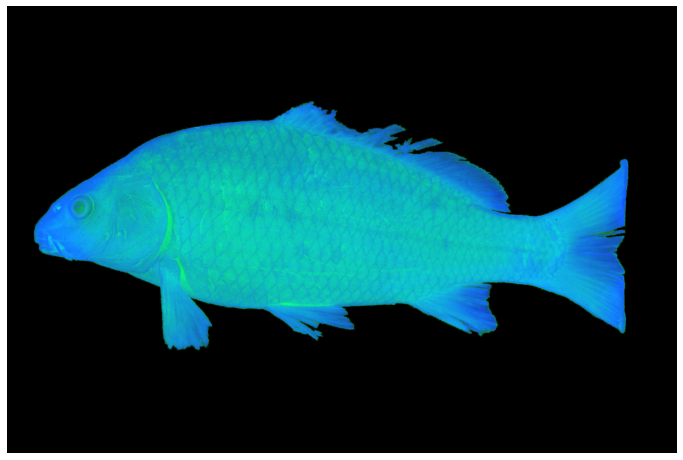

In [7]:
fig1, ax1 = plt.subplots(figsize=(12,10))
ax1.imshow(imageSideFull)
ax1.axis('off')
fig1.savefig(Path(figurePath).joinpath('baseImage.pdf'), facecolor='w', bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(12,10))
ax2.imshow(s, cmap='gray')
ax2.axis('off')
fig2.savefig(Path(figurePath).joinpath('sChannel.pdf'), facecolor='w', bbox_inches='tight')

fig3, ax3 = plt.subplots(figsize=(12, 10))
ax3.imshow(v, cmap='gray')
ax3.axis('off')
fig3.savefig(Path(figurePath).joinpath('vChannel.pdf'), facecolor='w', bbox_inches='tight')

fig4, ax4 = plt.subplots(figsize=(12, 10))
ax4.imshow(hsvSideFull_processed)
ax4.axis('off')
fig4.savefig(Path(figurePath).joinpath('hsvCombined.pdf'), facecolor='w', bbox_inches='tight')

In [8]:
# https://stackoverflow.com/questions/5906693/how-to-reduce-the-number-of-colors-in-an-image-with-opencv
def kmeans_color_quantization(image, clusters=2, rounds=1):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    compactness, labels, centers = cv2.kmeans(Z,
            clusters, 
            None,
            criteria, 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

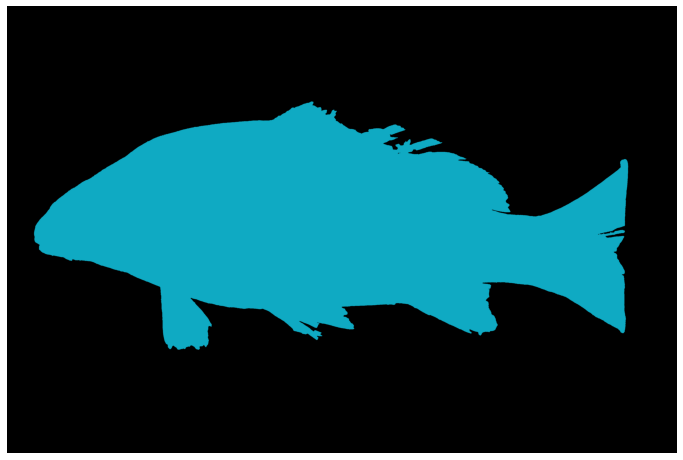

In [9]:
result = kmeans_color_quantization(hsvSideFull_processed)
fig5, ax5 = plt.subplots(figsize=(12,10))
ax5.imshow(result)
ax5.axis('off')
fig5.savefig(Path(figurePath).joinpath('kMeans.pdf'), facecolor='w', bbox_inches='tight')

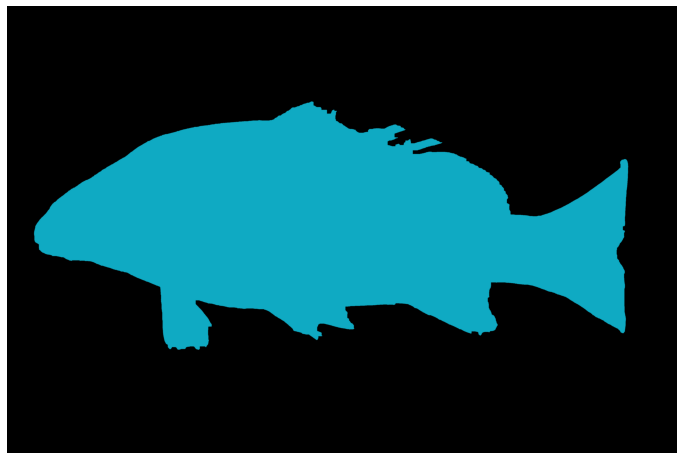

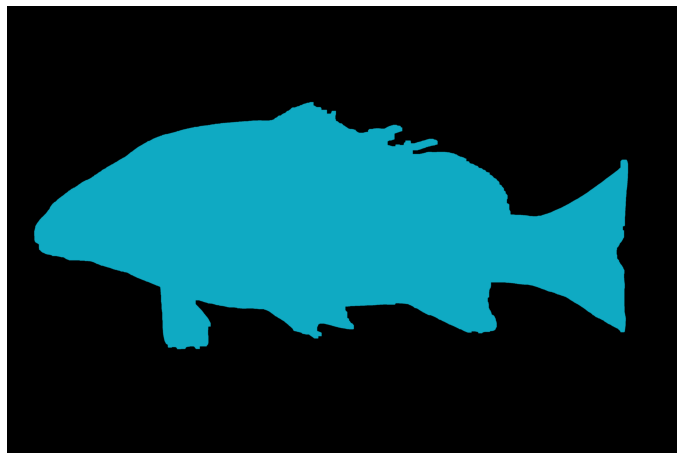

In [10]:
kernal = np.ones((21,21), np.uint8)
# Morphological Close
closeImg = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernal)
fig6, ax6 = plt.subplots(figsize=(12,10))
ax6.imshow(closeImg)
ax6.axis('off')
#fig6.savefig(Path(figurePath).joinpath('closeImg.png'), facecolor='w', bbox_inches='tight')

# Morhpological Open
openImg = cv2.morphologyEx(closeImg, cv2.MORPH_OPEN, kernal)
fig7, ax7 = plt.subplots(figsize=(12,10))
ax7.imshow(openImg)
ax7.axis('off')
fig7.savefig(Path(figurePath).joinpath('openImg.pdf'), facecolor='w', bbox_inches='tight')

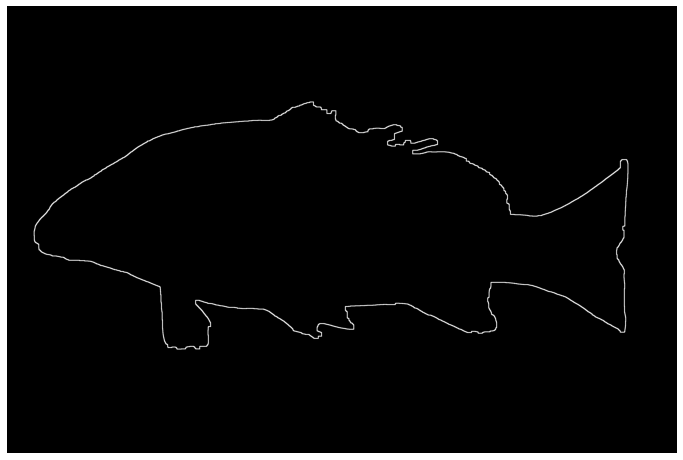

In [11]:
edged = cv2.Canny(openImg,100, 200)
edged_dialate = cv2.dilate(edged, np.ones((5,5), 'uint8'), iterations=1)
fig8, ax8 = plt.subplots(figsize=(12,10))
ax8.imshow(edged_dialate, cmap="gray")
ax8.axis('off')
fig8.savefig(Path(figurePath).joinpath('cannyEdge.pdf'), facecolor='w', bbox_inches='tight')

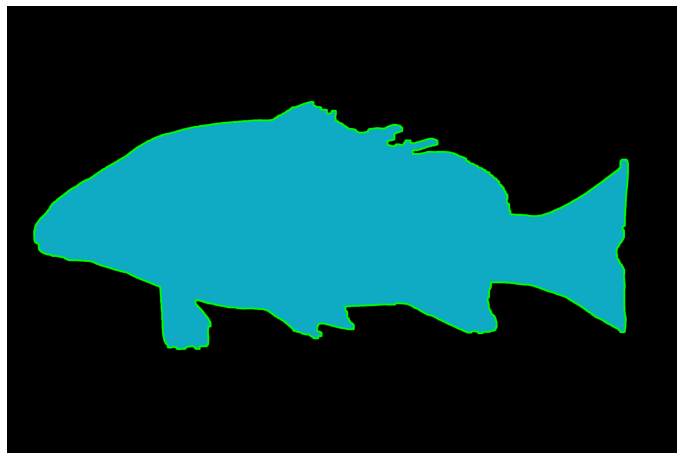

In [12]:
contours, hierarchy = cv2.findContours(edged,  
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cnts = sorted(contours, key=cv2.contourArea, reverse=True)

cv2.drawContours(openImg, contours, 0, (0, 255, 0), 10)

fig9, ax9 = plt.subplots(figsize=(12,10))
ax9.imshow(openImg)
ax9.axis('off')
fig9.savefig(Path(figurePath).joinpath('finalImage.pdf'), facecolor='w', bbox_inches='tight')

In [13]:
imagePathSide = fu.get_image_files(imagePath, 'scannedSalmonSideNF.png')

# import images
sideImg = cv2.imread(imagePathSide[0].as_posix())

imagePathTop = fu.get_image_files(imagePath, 'scannedSalmonTopNF.png')

# import images
topImg = cv2.imread(imagePathTop[0].as_posix())

cxySide, pointsSide, sideContours, sideHull = process_side([sideImg, imageSideFull])
cntsSideFull = sideContours[1]
cntsSide = sideContours[0]

cxyTop, pointsTop, topContours, topHull = process_top([topImg])
cntsTopFull = topContours[1]
cntsTop = topContours[0]

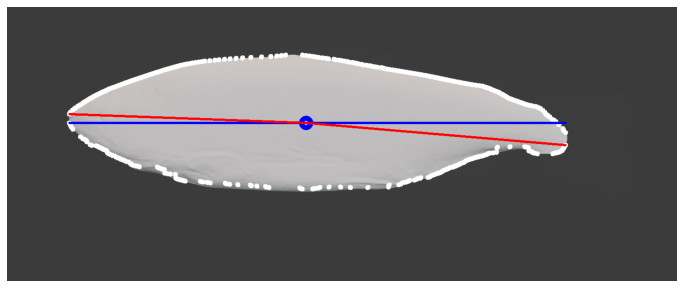

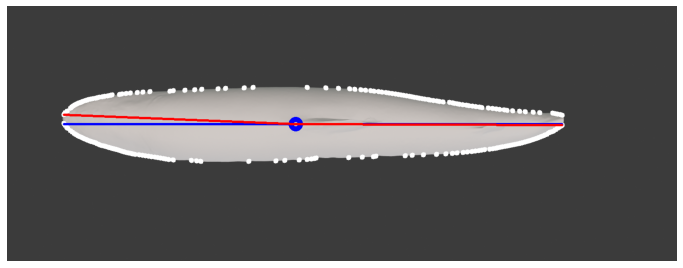

In [14]:
#([cxSide, cySide], [extLeft, extRight, midPoint_left, midPoint_right], divideLine, [cntsSide, cntsSideFull], [tHullSide, bHullSide])
#([cxTop, cyTop], [leftMost, rightMost], divideLine, [cntsTop, cntsTopFull], [tHullTop, bHullTop])

cv2.drawContours(sideImg, cntsSide, -1, (255, 255, 255), 10)
# draw in half line
cv2.circle(sideImg, (cxySide[0], cxySide[1]), 10, (0, 0, 255), 10)
cv2.line(sideImg, (pointsSide[0][0], cxySide[1]), (pointsSide[1][0], cxySide[1]), (0, 0, 255), 3)
# draw in divide line
cv2.line(sideImg, pointsSide[0], (cxySide[0], cxySide[1]), (255, 0, 0), 3)
cv2.line(sideImg, pointsSide[1], (cxySide[0], cxySide[1]), (255, 0, 0), 3)

cv2.drawContours(topImg, cntsTop, -1, (255, 255, 255), 10)
# draw in half line
cv2.circle(topImg, (cxyTop[0], cxyTop[1]), 10, (0, 0, 255), 10)
cv2.line(topImg, (pointsTop[0][0], cxyTop[1]), (pointsTop[1][0], cxyTop[1]), (0, 0, 255), 3)
# Draw in divide line
cv2.line(topImg, pointsTop[0], (cxyTop[0], cxyTop[1]), (255, 0, 0), 3)
cv2.line(topImg, pointsTop[1], (cxyTop[0], cxyTop[1]), (255, 0, 0), 3)

fig10, ax10 = plt.subplots(figsize=(12,10))
ax10.imshow(sideImg)
ax10.axis('off')
fig10.savefig(Path(figurePath).joinpath('sideContourImage.pdf'), facecolor='w', bbox_inches='tight')

fig11, ax11 = plt.subplots(figsize=(12,10))
ax11.imshow(topImg)
ax11.axis('off')
fig11.savefig(Path(figurePath).joinpath('topContourImage.pdf'), facecolor='w', bbox_inches='tight')

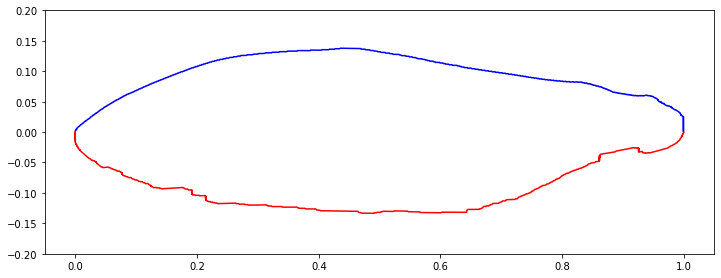

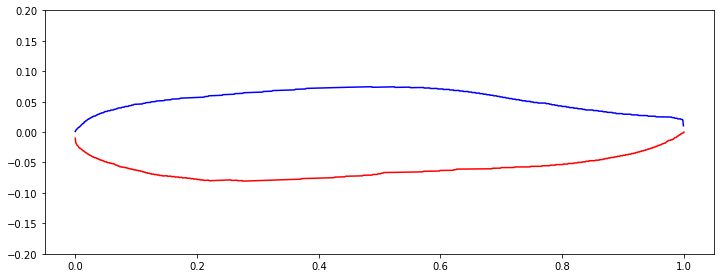

In [17]:
fig12, ax12 = plt.subplots(figsize=(12,10))
ax12.plot(sideHull[0][0], sideHull[0][1], 'b')
ax12.plot(sideHull[1][0], sideHull[1][1], 'r')
ax12.set_aspect('equal')
ax12.set_ylim([-0.20, 0.20])
#ax12.axis('off')
fig12.savefig(Path(figurePath).joinpath('sideContour.pdf'), facecolor='w', bbox_inches='tight')

fig13, ax13 = plt.subplots(figsize=(12,10))
ax13.plot(topHull[0][0], topHull[0][1], 'b')
ax13.plot(topHull[1][0], topHull[1][1], 'r')
ax13.set_aspect('equal')
ax13.set_ylim([-0.20, 0.20])
#ax13.axis('off')
fig13.savefig(Path(figurePath).joinpath('topContour.pdf'), facecolor='w', bbox_inches='tight')